In [1]:
if True:
    def warn(*args, **kwargs):
        pass
    import warnings
    warnings.warn = warn


import os
import time
import sys

import torch as t
from torch import nn
from torch.autograd import Variable

class simple_model(nn.Module):
    def __init__(self, num_hidden, hidden_dim=24, drop_probab=.5):
        super(simple_model, self).__init__()
        
        ####
        self.fc1 = nn.Linear(23, hidden_dim)
        self.fc_hidden = nn.ModuleList([nn.Linear(hidden_dim, hidden_dim) for i in range(num_hidden)])
        self.fc2 = nn.Linear(hidden_dim, 8)
        self.outLayer = nn.Linear(8, 1)
#         self.softmax = nn.Softmax(-1)
        self.sigmoid = nn.Sigmoid()
        self.num_hidden = num_hidden
        self.drop_probab = drop_probab
        self.dropout = nn.functional.dropout
        ####

    def forward(self, features):
        features = self.fc1(features)
        features = self.dropout(features, p=self.drop_probab)
#         for i in range(self.num_hidden):
#             features = self.fc_hidden[i](features)
        features = self.fc2(features)
        features = self.dropout(features, p=self.drop_probab)
        logit = self.outLayer(features)
        probab = self.sigmoid(logit)
        return probab
    

In [2]:
import json
import numpy as np
import random

In [3]:
Final_Samples = json.load(open('Final_Samples.json', 'r')) 
negative_samples = Final_Samples[370:]
random.seed(7)
random.shuffle(negative_samples)
Final_Samples = Final_Samples[:370] + negative_samples[:370]
len([x[1] for x in Final_Samples if x[1] == 1]), len([x[1] for x in Final_Samples if x[1] == 0])
Final_Samples = np.array(Final_Samples)
Final_Samples, Final_Samples.reshape(10, -1, 2).shape

(array([['018_S_0633', '1'],
        ['037_S_0467', '1'],
        ['128_S_0517', '1'],
        ...,
        ['099_S_4202', '0'],
        ['072_S_4445', '0'],
        ['029_S_2395', '0']], dtype='<U10'),
 (10, 74, 2))

In [4]:
simple_model(0)

simple_model(
  (fc1): Linear(in_features=23, out_features=24, bias=True)
  (fc_hidden): ModuleList()
  (fc2): Linear(in_features=24, out_features=8, bias=True)
  (outLayer): Linear(in_features=8, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [5]:
import torch
from torch.utils import data

class dataSet(data.Dataset):
    def __init__(self, Final_Samples, PRS_feature_matrix, usable_samples_ADNI):
        super(dataSet, self).__init__()  
        self.data_len = len(Final_Samples)
        self.usable_samples_ADNI = usable_samples_ADNI
        self.Final_Samples = Final_Samples
        self.PRS_feature_matrix = PRS_feature_matrix
        
    def __getitem__(self, index):
        features = torch.from_numpy(self.PRS_feature_matrix[self.usable_samples_ADNI[self.Final_Samples[index][0]]]).float()
        label = torch.tensor([float(self.Final_Samples[index][1])]).float()
        return features, label
    
    def update_prs_features(self, mean, std):
        self.PRS_feature_matrix = (self.PRS_feature_matrix - mean) / std
        
    def get_mean_std(self):
        mean = self.PRS_feature_matrix.mean(0)
        std = self.PRS_feature_matrix.std(0)
        return mean, std
        
    def __len__(self):
        return self.data_len

In [6]:
# Final_Samples
usable_samples_ADNI = json.load(open('./usable_samples_ADNI.json'))
PRS_feature_matrix = np.load('./PRS_feature_matrix.npy')

def random_samples(total_folds, random_seed=None):
    Final_Samples = json.load(open('Final_Samples.json', 'r')) 
    negative_samples = Final_Samples[370:]
    if random_seed is not None: 
        random.seed(random_seed * 2)
    random.shuffle(negative_samples)
    Final_Samples = Final_Samples[:370] + negative_samples[:370]   
    if random_seed is not None: 
        random.seed(random_seed)
    random.shuffle(Final_Samples)
    Final_Samples = np.array(Final_Samples)
    N_splits = Final_Samples.reshape(total_folds, -1, 2)
    return N_splits

def generate_datasets(N_splits, fold_num):
    test_samples = N_splits[fold_num:fold_num+1].reshape([-1, 2])
    train_samples = np.concatenate([N_splits[0:fold_num],N_splits[fold_num+1:]], 0).reshape([-1, 2])
    train_set = dataSet(Final_Samples=train_samples, 
                        PRS_feature_matrix=PRS_feature_matrix, 
                        usable_samples_ADNI=usable_samples_ADNI)
    val_set = dataSet(Final_Samples=test_samples, 
                      PRS_feature_matrix=PRS_feature_matrix, 
                      usable_samples_ADNI=usable_samples_ADNI)
    mean, std = train_set.get_mean_std()
    train_set.update_prs_features(mean, std)
    val_set.update_prs_features(mean, std)
    
    return train_set, val_set

def generate_loader(train_set, val_set, num_workers):
    train_batch_size = train_set.__len__()
    val_batch_size = val_set.__len__()
    train_loader = torch.utils.data.DataLoader(train_set,
                                              batch_size=train_batch_size,
                                              shuffle=True,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_set,
                                              batch_size=val_batch_size,
                                              shuffle=False,
                                              pin_memory=(torch.cuda.is_available()),
                                              num_workers=num_workers)
    return train_loader, val_loader



In [7]:
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc


def epoch(model, optimizer, criterion, is_training, loader):
    pred = []
    true = []
    total_loss = 0.
    
    for batch_idx, (features, label) in enumerate(loader):
        features = torch.autograd.Variable(features.to(DEVICE).float())
        label = torch.autograd.Variable(label.to(DEVICE).float())
#         print(features.shape, label.shape)
        probab = model(features)
    
        if is_training:  
            loss = criterion(probab, label)
            ## compute gradient and do SGD step 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
#             print(batch_idx, ':', loss) 
        pred += probab.detach().cpu().numpy().tolist()
        true += label.detach().cpu().numpy().tolist()
    
    pred, true, total_loss = np.array(pred).reshape([-1]), np.array(true).reshape([-1]), total_loss
    pred_binary = (pred > .5).astype(float)
    precision, recall, fscore, support = precision_recall_fscore_support(true, pred_binary)
    auroc = roc_auc_score(true, pred)
    p, r, thresholds = precision_recall_curve(true, pred)
    auprc = auc(r, p)
    acc = (pred_binary==true).mean()
    
    return precision[1], recall[1], fscore[1], support, auroc, auprc, acc, total_loss, pred, pred_binary, true
    


In [8]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

import shap
from copy import deepcopy

usable_indices = [usable_samples_ADNI[Final_Samples[i][0]] for i in range(len(Final_Samples))]
usable_features = PRS_feature_matrix[usable_indices]
usable_labels = np.array([float(Final_Samples[i][1]) for i in range(len(Final_Samples))])
usable_features = torch.autograd.Variable(torch.from_numpy(usable_features)).to(DEVICE).float()

GENERATE_SHAP = True
total_epochs = 100 #150 
num_hidden_list = [1]
random_integers = [2, 6, 108, 90, 5]
folds_list = [37*2]#[37]

shap_values_list = []
for num_hidden in num_hidden_list:
    print(f'NH:{num_hidden}')
    global_best_acc_val = 0.
    for total_folds in folds_list:
        print(f'\n#F{total_folds}')
        for random_seed in random_integers:
            N_splits = random_samples(total_folds=total_folds, random_seed=random_seed)
            accuracies = []
            temp_shap_values = np.zeros([740, 23])
            for fold_num in range(total_folds):
    #             print(f'fold-{fold_num}:')
                train_set, val_set = generate_datasets(N_splits=N_splits, fold_num=fold_num)
                train_loader, val_loader = generate_loader(train_set=train_set, val_set=val_set, num_workers=0)
                model = simple_model(num_hidden=num_hidden, hidden_dim=32, drop_probab=.8)
                model = model.to(DEVICE)
                optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
                criterion = torch.nn.BCEWithLogitsLoss() 
                best_acc_val = 0.
                model_best = None
                for epoch_num in range(total_epochs):
                    model.train()
                    precision, recall, fscore, support, auroc, auprc, acc_train, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=True, 
                                                                                             loader=train_loader)
                    model.eval()
                    precision, recall, fscore, support, auroc, auprc, acc_val, total_loss, pred, pred_binary, true = epoch(model=model, optimizer=optimizer, 
                                                                                             criterion=criterion, is_training=False, 
                                                                                             loader=val_loader)
                    if acc_val > best_acc_val:
                        best_acc_val = acc_val
                        if acc_val > global_best_acc_val:
                            global_best_acc_val = acc_val
    #                         print('global updated!')
                        model_best = deepcopy(model)
    #                     print(f'#F:{total_folds}| seed:{random_seed}, fold:{fold_num}, epoch:{epoch_num} -> local:{best_acc_val}, global:{global_best_acc_val}')  
                    if epoch_num + 1 == total_epochs:
    #                     print(f'LAST_Epoch:{epoch_num}, train_acc:{acc_train}, val_acc:{acc_val}, local_best:{best_acc_val}, global_best:{global_best_acc_val}')
                        pass
                accuracies += [best_acc_val]
                if GENERATE_SHAP:
                    explainer = shap.GradientExplainer(model_best.to(DEVICE), usable_features,
                                                       batch_size=usable_features.shape[0]) #https://shap-lrjball.readthedocs.io/en/latest/generated/shap.KernelExplainer.html
                    shap_values = explainer.shap_values(usable_features, nsamples=100)
                    temp_shap_values += shap_values
            if GENERATE_SHAP:
                temp_shap_values /= total_folds
                shap_values_list += [temp_shap_values] 
            print(f'random_seed:{random_seed}:', np.mean(accuracies), np.std(accuracies))
            
    print(f'global_best_acc_val:{global_best_acc_val}')

C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1)

NH:1

#F74
random_seed:2: 0.8486486486486488 0.09620254989490643
random_seed:6: 0.8581081081081081 0.08854187703179009
random_seed:108: 0.8486486486486486 0.08421857541017776
random_seed:90: 0.8405405405405405 0.09714703111141314
random_seed:5: 0.8391891891891892 0.09126375137785431
global_best_acc_val:1.0


In [17]:
usable_features = usable_features.cpu().detach().numpy().astype(np.float64)
shap_values_list[0].shape

import pickle
pickle.dump(shap_values_list, open('shap_values_list.pkl', 'wb'))
shap_values = np.sum(shap_values_list, axis=0).astype(np.float64)

In [18]:
shap_values_list
# print the JS visualization code to the notebook
shap.initjs()
shap.force_plot(.5, shap_values[0,:], usable_features[0, :], link="logit")

In [19]:
shap.force_plot(.5, shap_values[:,:], usable_features[:, :], link="logit")

In [23]:
# traits[20]

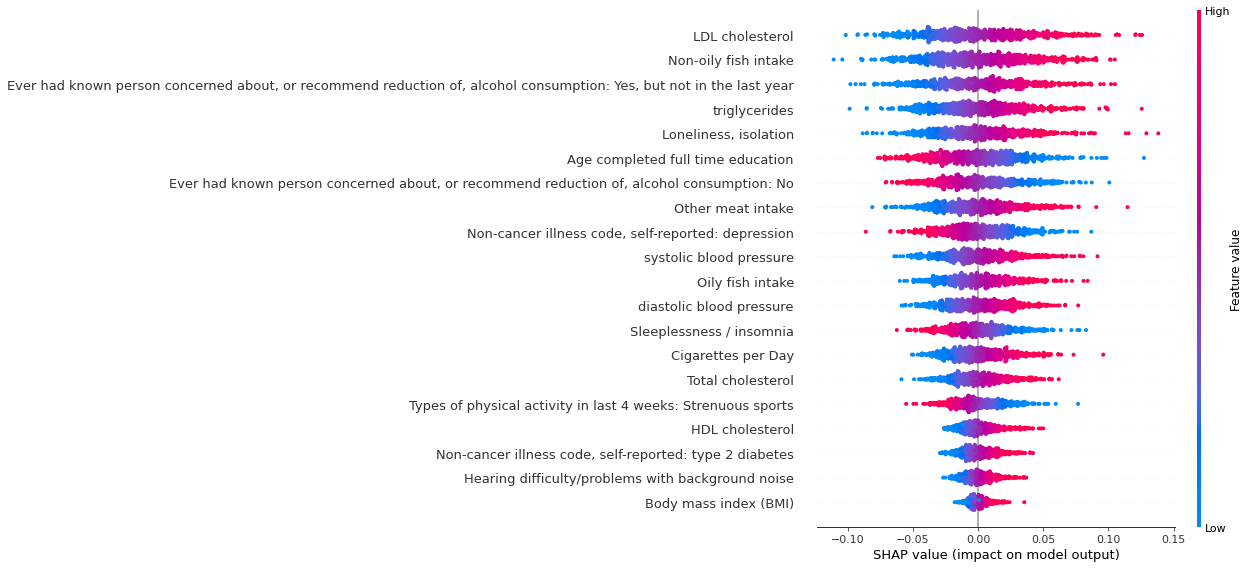

In [24]:
GWAS_IDS = ['ieu-b-109', 'ukb-b-12064', 'ukb-b-13806', 'ukb-d-20405_0', 'ieu-b-38', 'ukb-b-6134', 'ieu-b-110', 'ukb-b-17627', 'ukb-b-19953', 'ukb-b-8476', 'ukb-d-20405_1', 'ukb-d-20405_2', 'ukb-b-2209', 'ukb-b-4424', 'ukb-b-7663', 'ukb-b-18275', 'ukb-b-770', 'met-d-Total_C', 'ieu-b-25', 'ieu-b-111', 'ukb-b-3957', 'ieu-b-39', 'ukb-b-6324']
traits = ['HDL cholesterol', 'Non-cancer illness code, self-reported: depression', 'Non-cancer illness code, self-reported: type 2 diabetes', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: No', 'systolic blood pressure', 'Age completed full time education', 'LDL cholesterol', 'Non-oily fish intake', 'Body mass index (BMI)', 'Loneliness, isolation', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, but not in the last year', 'Ever had known person concerned about, or recommend reduction of, alcohol consumption: Yes, during the last year', 'Oily fish intake', 'Sleep duration', 'Types of physical activity in last 4 weeks: Strenuous sports', 'Hearing difficulty/problems with background noise', 'Other meat intake', 'Total cholesterol', 'Cigarettes per Day', 'triglycerides', 'Sleeplessness / insomnia', 'diastolic blood pressure', 'Processed meat intake']

# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='dot')

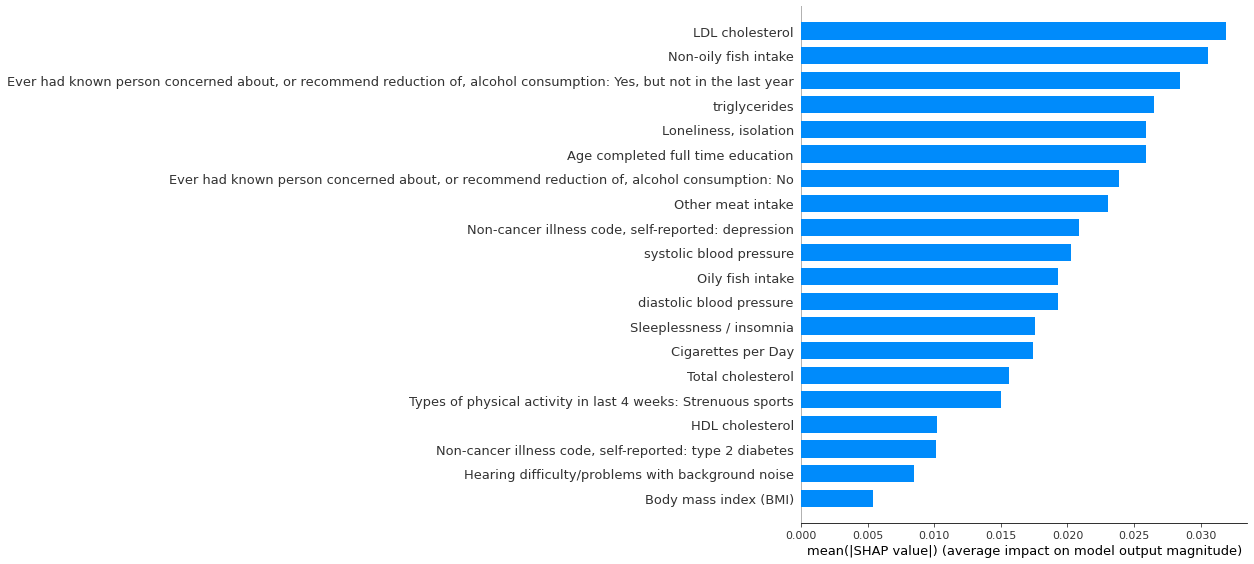

In [25]:
# https://shap-lrjball.readthedocs.io/en/latest/generated/shap.summary_plot.html?highlight=beeswarm#shap.summary_plot
shap.summary_plot(shap_values, features=usable_features, feature_names=traits, plot_type='bar')

In [ ]:
# Hidden Layers: 3
# Learning rate: 0.001, epochs 100
# #F37
# random_seed:2: 0.7743243243243244 0.0776527453976143
# random_seed:6: 0.7418918918918919 0.05636933409355193
# random_seed:108: 0.7648648648648649 0.06136385156617693
# random_seed:90: 0.7527027027027028 0.0646674925081373
# random_seed:5: 0.7648648648648649 0.06352788796509815
# global_best_acc_val:0.95

In [ ]:
# Hidden Layers: 3
# Learning rate: 0.001, epochs 100
# #F74
# random_seed:2: 0.845945945945946 0.09752226244685794
# random_seed:6: 0.8405405405405405 0.1064398306352174
# random_seed:108: 0.8472972972972973 0.07749973491318739
# random_seed:90: 0.8391891891891893 0.08513513513513514
# random_seed:5: 0.8527027027027028 0.07017925498702046
# global_best_acc_val:1.0

In [ ]:
# Hidden Layers: 3
# Learning rate: 0.001, epochs 100
# #F74
# random_seed:2: 0.677027027027027 0.144771298948616
# random_seed:6: 0.677027027027027 0.13208033724122614
# random_seed:108: 0.6716216216216216 0.14843350524208282
# random_seed:90: 0.6783783783783782 0.13682724387942852
# random_seed:5: 0.6500000000000001 0.13177581289775778
# global_best_acc_val:1.0

In [ ]:
# Hidden Layers: 3
# Learning rate: 0.001, epochs 200
# #F74
# random_seed:2: 0.6716216216216216 0.12683280148488987
# random_seed:6: 0.6972972972972974 0.13653330746286582
# random_seed:108: 0.6756756756756758 0.12925024001317129
# random_seed:90: 0.681081081081081 0.12910887472968852
# random_seed:5: 0.681081081081081 0.12156154672458931
# global_best_acc_val:1.0


In [ ]:
# Hidden Layers: 3
# # Learning rate: 0.001, epochs 150
# #F74
# random_seed:2: 0.6864864864864865 0.14825500704759437
# random_seed:6: 0.6945945945945947 0.13545907120153156
# random_seed:108: 0.7027027027027029 0.1173732473005863
# random_seed:90: 0.6783783783783784 0.1265661564753308
# random_seed:5: 0.6918918918918918 0.13126902102249613
# global_best_acc_val:1.0

In [ ]:
# Hidden Layers: 3
# # Learning rate: 0.001, epochs 100
# #F74
# random_seed:2: 0.6824324324324323 0.13592337677361732
# random_seed:6: 0.7040540540540541 0.12886111231612285
# random_seed:108: 0.672972972972973 0.12975787982873305
# random_seed:90: 0.6716216216216215 0.10593250052576224
# random_seed:5: 0.677027027027027 0.12030063388354634
# global_best_acc_val:1.0

In [ ]:
# Hidden Layers: 2
# #F74
# random_seed:2: 0.677027027027027 0.1466262921164212
# random_seed:6: 0.6756756756756755 0.14594594594594595
# random_seed:108: 0.6837837837837837 0.13658679749722463
# random_seed:90: 0.6783783783783784 0.1378113382052104
# random_seed:5: 0.6756756756756758 0.13336680855649005
# global_best_acc_val:1.0

# Hidden Layers: 1
# #F74
# random_seed:2: 0.6445945945945946 0.14059900031543793
# random_seed:6: 0.6702702702702703 0.138261141215445
# random_seed:108: 0.6270270270270272 0.14265560238266645
# random_seed:90: 0.6486486486486486 0.11768400571393105
# random_seed:5: 0.6378378378378377 0.13426748484728887
# global_best_acc_val:1.0